In [16]:
import os
import pyart
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta

from metpy import plots, calc
from metpy.units import units
import profile_io as io
from csu_radartools import csu_kdp, csu_fhc


import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'openradartools'

In [17]:
def det_sys_phase_gf(radar, gatefilter, phidp_field=None, first_gate=30, sweep=0):
    """
    Determine the system phase.

    Parameters
    ----------
    radar : Radar
        Radar object for which to determine the system phase.
    gatefilter : Gatefilter
        Gatefilter object highlighting valid gates.
    phidp_field : str, optional
        Field name within the radar object which represents
        differential phase shift. A value of None will use the default
        field name as defined in the Py-ART configuration file.
    first_gate : int, optional
        Gate index for where to being applying the gatefilter.

    Returns
    -------
    sys_phase : float or None
        Estimate of the system phase. None is not estimate can be made.

    """
    # parse the field parameters
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')
    phidp = radar.fields[phidp_field]['data'][:, first_gate:]
    first_ray_idx = radar.sweep_start_ray_index['data'][sweep]
    last_ray_idx = radar.sweep_end_ray_index['data'][sweep]
    is_meteo = gatefilter.gate_included[:, first_gate:]
    return _det_sys_phase_gf(phidp, first_ray_idx, last_ray_idx, is_meteo)

def _det_sys_phase_gf(phidp, first_ray_idx, last_ray_idx, radar_meteo):
    """ Determine the system phase, see :py:func:`det_sys_phase`. """
    good = False
    phases = []
    for radial in range(first_ray_idx, last_ray_idx + 1):
        meteo = radar_meteo[radial, :]
        mpts = np.where(meteo)
        if len(mpts[0]) > 25:
            good = True
            msmth_phidp = pyart.correct.phase_proc.smooth_and_trim(phidp[radial, mpts[0]], 9)
            phases.append(msmth_phidp[0:25].min())
    if not good:
        return None
    return np.median(phases)

def phidp_bringi(radar, gatefilter, phidp_field="PHI_UNF", refl_field='DBZ', bad=-9999.0):
    """
    Compute PHIDP and KDP Bringi.
    Parameters
    ==========
    radar:
        Py-ART radar data structure.
    gatefilter:
        Gate filter.
    unfold_phidp_name: str
        Differential phase key name.
    refl_field: str
        Reflectivity key name.
    Returns:
    ========
    phidpb: ndarray
        Bringi differential phase array.
    kdpb: ndarray
        Bringi specific differential phase array.
    """
    dz = radar.fields[refl_field]['data'].copy().filled(bad)
    dp = radar.fields[phidp_field]['data'].copy().filled(bad)
    #ensure any NaN have been replaced with the bad value
    dz[np.isnan(dz)] = bad
    dp[np.isnan(dp)] = bad
    
    # Extract dimensions
    rng = radar.range['data']
    azi = radar.azimuth['data']
    dgate = rng[1] - rng[0]
    [R, A] = np.meshgrid(rng, azi)

    # Compute KDP bringi.
    kdpb, phidpb, _ = csu_kdp.calc_kdp_bringi(dp, dz, R.astype(float) / 1e3, gs=float(dgate), bad=bad, thsd=12.0,
                                              window=6.0, std_gate=11)

    # Mask array
    phidpb = np.ma.masked_where(phidpb == bad, phidpb)
    kdpb = np.ma.masked_where(kdpb == bad, kdpb)
    
    #fill
    phidpb = fill_phi(phidpb.filled(np.NaN))
    
    #set fill values
    np.ma.set_fill_value(phidpb, bad)
    np.ma.set_fill_value(kdpb, bad)
    
    # Get metadata.
    phimeta = pyart.config.get_metadata("differential_phase")
    phimeta['data'] = phidpb
    phimeta['comments'] = "Corrected using technique developed by Lang et al. (2007) doi: 10.1175/JCLI4082.1; " \
                          "implementation from https://github.com/CSU-Radarmet/CSU_RadarTools"
    kdpmeta = pyart.config.get_metadata("specific_differential_phase")
    kdpmeta['data'] = kdpb
    kdpmeta['comments'] = "Corrected using technique developed by Lang et al. (2007) doi: 10.1175/JCLI4082.1; " \
                          "implementation from https://github.com/CSU-Radarmet/CSU_RadarTools"
    return phimeta, kdpmeta

In [2]:
level1_ppi_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV/2023072422_30_ODIMH5_PVOL6S_VOL_CASCV.h5'
level1b_ppi_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV/2023072422_30_ODIMH5_PVOL6S_VOL.qc.cascv.h5'

level_1_sweep = 14
level_1b_sweep = 2

In [3]:
radar = pyart.aux_io.read_odim_h5(level1_ppi_ffn)
#calclate distance from hailsonde flight to radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
print('radar', radar_lat, radar_lon)
launch_lat = 53.39513
launch_lon = -116.080467




radar 53.56061935424805 -114.14446258544922


In [ ]:
fig = plt.figure(figsize=(16, 10))

radar = pyart.aux_io.read_odim_h5(level1_ppi_ffn)
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(231)
display.plot_ppi('reflectivity_horizontal', sweep=level_1_sweep)
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

ax = fig.add_subplot(232)
display.plot_ppi('velocity_horizontal', sweep=level_1_sweep, title='VEL')
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

ax = fig.add_subplot(233)
display.plot_ppi('differential_reflectivity', sweep=level_1_sweep, title='ZDR', vmin=-2, vmax=6)
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

radar = pyart.aux_io.read_odim_h5(level1b_ppi_ffn)
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(234)
display.plot_ppi('reflectivity_horizontal', sweep=level_1b_sweep)
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

ax = fig.add_subplot(235)
display.plot_ppi('velocity_horizontal', sweep=level_1b_sweep, title='QC VEL')
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

ax = fig.add_subplot(236)
display.plot_ppi('differential_reflectivity', sweep=level_1b_sweep, title='QC ZDR', vmin=-2, vmax=6)
ax.set_xlim(-150, -125)
ax.set_ylim(-30, -5)

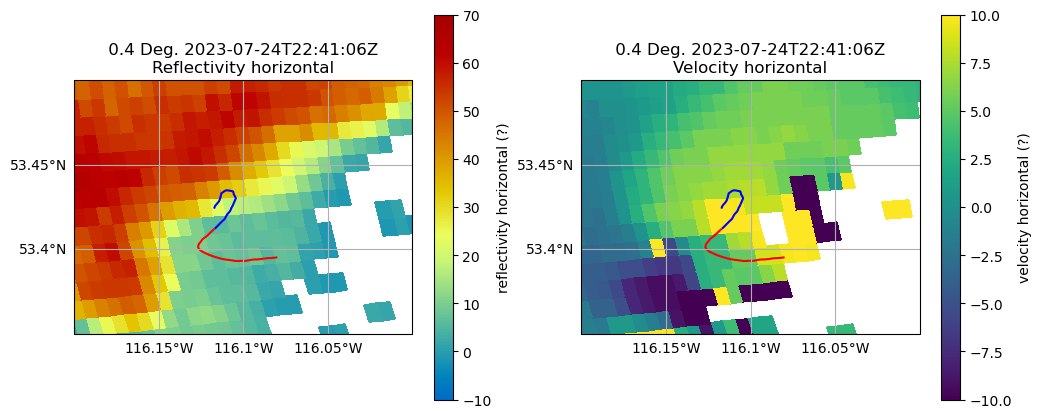

In [29]:
#load radar data
ppi_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV/2023072422_42_ODIMH5_PVOL6S_VOL_CASCV.h5'
radar = pyart.aux_io.read_odim_h5(ppi_ffn)
display = pyart.graph.RadarMapDisplay(radar)

filename = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/2023-07-24_1631_9931.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=321)

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
display.plot_ppi_map('reflectivity_horizontal', 
                        sweep=16, ax=ax, vmin=-10, vmax=70,
                        lon_lines=np.arange(-117, -115, 0.05),
                        lat_lines=np.arange(53, 54, 0.05),
                        min_lon=-116.2,
                        max_lon=-116.0,
                        min_lat=53.35,
                        max_lat=53.5)
nan_filter = np.isnan(with_balloon_profile['lat'])
display.plot_line_geo(np.array(with_balloon_profile['lon'])[~nan_filter], np.array(with_balloon_profile['lat'])[~nan_filter], 'r-')
nan_filter = np.isnan(no_balloon_profile['lat'])
display.plot_line_geo(np.array(no_balloon_profile['lon'])[~nan_filter], np.array(no_balloon_profile['lat'])[~nan_filter], 'b-')

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity_horizontal', 
                        sweep=16, ax=ax, vmin=-10, vmax=10,
                        lon_lines=np.arange(-117, -115, 0.05),
                        lat_lines=np.arange(53, 54, 0.05),
                        min_lon=-116.2,
                        max_lon=-116.0,
                        min_lat=53.35,
                        max_lat=53.5)
nan_filter = np.isnan(with_balloon_profile['lat'])
display.plot_line_geo(np.array(with_balloon_profile['lon'])[~nan_filter], np.array(with_balloon_profile['lat'])[~nan_filter], 'r-')
nan_filter = np.isnan(no_balloon_profile['lat'])
display.plot_line_geo(np.array(no_balloon_profile['lon'])[~nan_filter], np.array(no_balloon_profile['lat'])[~nan_filter], 'b-')


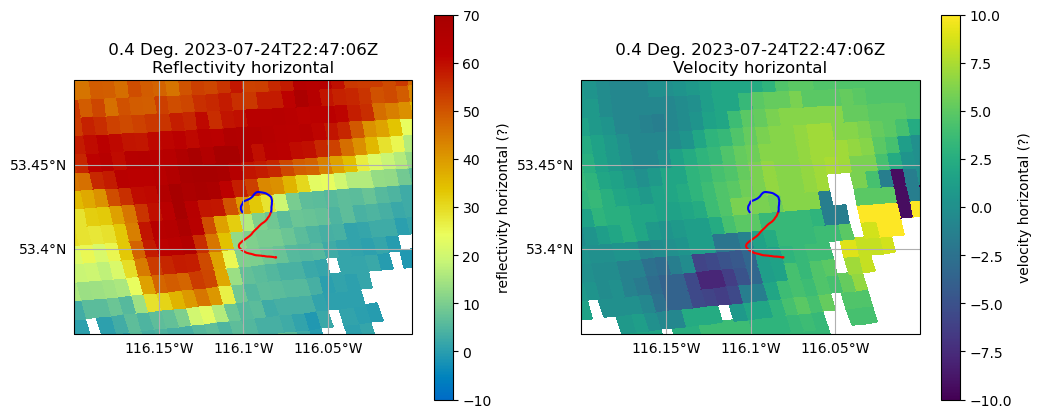

In [30]:
#load radar data
ppi_ffn = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV/2023072422_48_ODIMH5_PVOL6S_VOL_CASCV.h5'
radar = pyart.aux_io.read_odim_h5(ppi_ffn)
display = pyart.graph.RadarMapDisplay(radar)

filename = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/2023-07-24_1636_9935.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=321)

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
display.plot_ppi_map('reflectivity_horizontal', 
                        sweep=16, ax=ax, vmin=-10, vmax=70,
                        lon_lines=np.arange(-117, -115, 0.05),
                        lat_lines=np.arange(53, 54, 0.05),
                        min_lon=-116.2,
                        max_lon=-116.0,
                        min_lat=53.35,
                        max_lat=53.5)
nan_filter = np.isnan(with_balloon_profile['lat'])
display.plot_line_geo(np.array(with_balloon_profile['lon'])[~nan_filter], np.array(with_balloon_profile['lat'])[~nan_filter], 'r-')
nan_filter = np.isnan(no_balloon_profile['lat'])
display.plot_line_geo(np.array(no_balloon_profile['lon'])[~nan_filter], np.array(no_balloon_profile['lat'])[~nan_filter], 'b-')

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
display.plot_ppi_map('velocity_horizontal', 
                        sweep=16, ax=ax, vmin=-10, vmax=10,
                        lon_lines=np.arange(-117, -115, 0.05),
                        lat_lines=np.arange(53, 54, 0.05),
                        min_lon=-116.2,
                        max_lon=-116.0,
                        min_lat=53.35,
                        max_lat=53.5)
nan_filter = np.isnan(with_balloon_profile['lat'])
display.plot_line_geo(np.array(with_balloon_profile['lon'])[~nan_filter], np.array(with_balloon_profile['lat'])[~nan_filter], 'r-')
nan_filter = np.isnan(no_balloon_profile['lat'])
display.plot_line_geo(np.array(no_balloon_profile['lon'])[~nan_filter], np.array(no_balloon_profile['lat'])[~nan_filter], 'b-')

In [12]:
# for each 100 second interval, plot the trajectory of the hailsonde ontop of a 4 panel figure of the nearest xsection in space and time.

output_folder = '/g/data/kl02/jss548/hail-research/hailsonde/nhp_output'

#config for dataset
dataset1_config = {'split':271,'sondeid':'9931','timestamp':'2023-07-24_1631'}
dataset2_config = {'split':220,'sondeid':'9935','timestamp':'2023-07-24_1636'}

#set dataset
dataset_config = dataset2_config

#read data
row_to_split_profile = dataset_config['split']
timestamp = dataset_config['timestamp']
sonde_id = dataset_config['sondeid']
filename = f'/g/data/kl02/jss548/hail-research/hailsonde/20230724_hailsonde/{timestamp}_{sonde_id}.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=row_to_split_profile, remove_nan_rows=True)

gmt_offset = -6
snd_start_dt = datetime.strptime(os.path.basename(filename)[0:15], '%Y-%m-%d_%H%M') - timedelta(hours = gmt_offset)

#set interval
plot_interval = 100
plot_timesteps = np.arange(plot_interval,no_balloon_profile['time'][-1],plot_interval)

#load radars
radar_site_alt = 810 #m
radar_vols_path = '/g/data/kl02/jss548/hail-research/hailsonde/20230724_CASCV_subset'
radars, radar_dt_list = io.load_nhp_radar_data(radar_vols_path, 360)
    
    


100.0


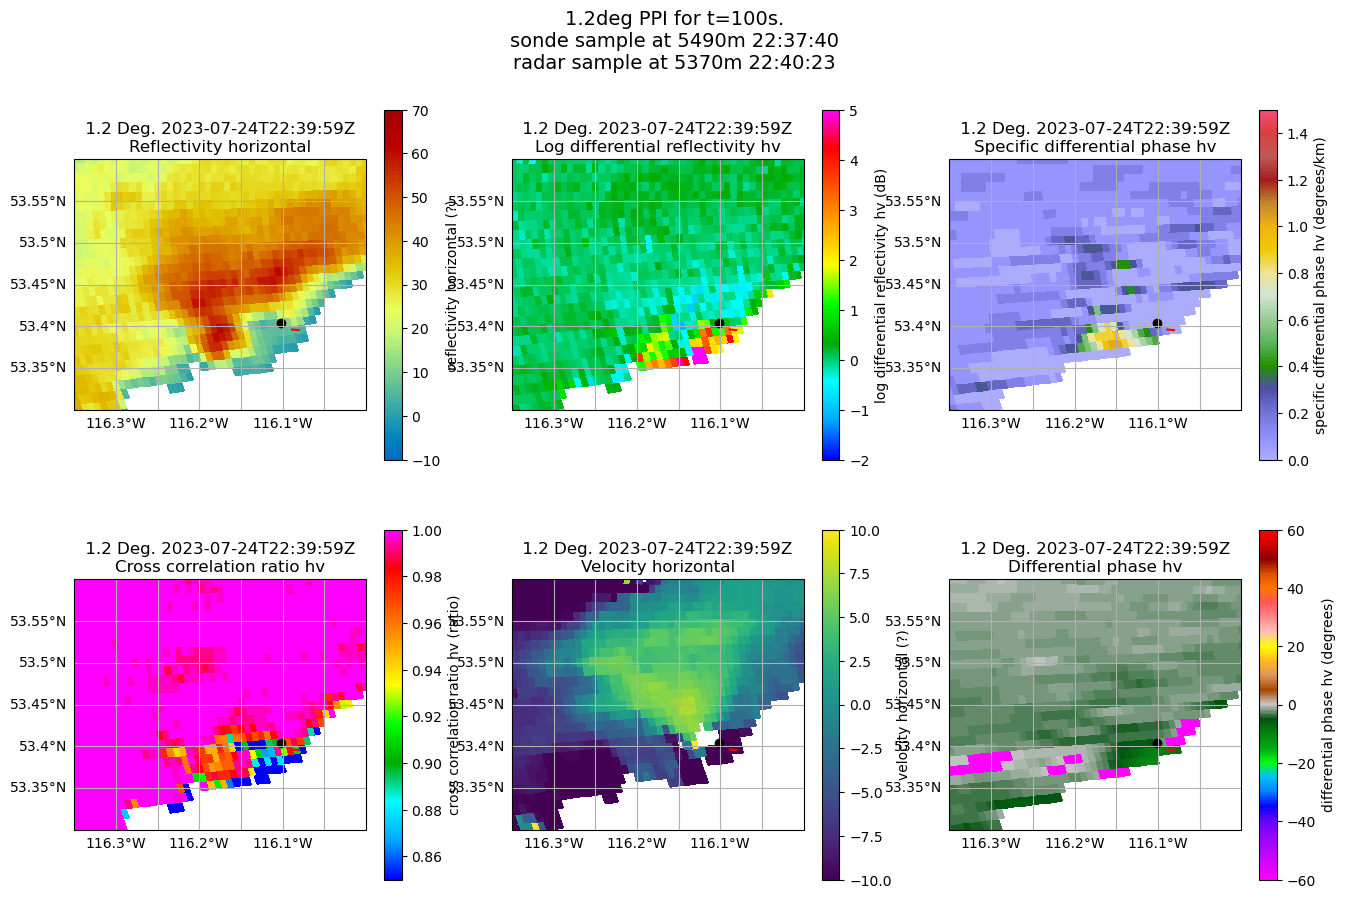

In [13]:
for timestep in plot_timesteps:
    #
    print(timestep)
    #set target time
    target_dt = snd_start_dt + timedelta(seconds = timestep)
    #find nearest timestep and extract profile data
    if timestep <= with_balloon_profile['time'][-1]:
        #ends within "with balloon" profile
        idx = io.find_nearest_idx(with_balloon_profile['time'], timestep)
        with_balloon_profile_subset = {}
        for field in with_balloon_profile:
            with_balloon_profile_subset[field] = with_balloon_profile[field][0:idx]
        no_balloon_profile_subset = None
        target_lat = with_balloon_profile['lat'][-1]
        target_lon = with_balloon_profile['lon'][-1]
        target_alt = with_balloon_profile['hght']._magnitude[-1]
    else:
        #ends within "no balloon" profile
        with_balloon_profile_subset = with_balloon_profile
        idx = io.find_nearest_idx(no_balloon_profile['time'], timestep)
        no_balloon_profile_subset = {}
        for field in no_balloon_profile:
            no_balloon_profile_subset[field] = no_balloon_profile[field][0:idx]
        target_lat = no_balloon_profile_subset['lat'][-1]
        target_lon = no_balloon_profile_subset['lon'][-1]
        target_alt = no_balloon_profile_subset['hght']._magnitude[-1]
    #find nearest radar volume
    radar_idx = io.find_nearest_dt_idx(target_dt, radar_dt_list)
    
    #find nearest ppi sweep in volume
    gate_lon = radars[radar_idx].gate_longitude['data']
    gate_lat = radars[radar_idx].gate_latitude['data']
    gate_alt = radars[radar_idx].gate_altitude['data'] + radar_site_alt
    ray_time = radars[radar_idx].time['data']
    ray_elevation = radars[radar_idx].elevation['data']
    dist = np.sqrt((io.degrees2meters(gate_lat - target_lat))**2 + (io.degrees2meters(gate_lon - target_lon))**2 + (gate_alt - target_alt)**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_lon.shape)
    sweep_idx = io.find_nearest_idx(radars[radar_idx].fixed_angle['data'], ray_elevation[min_dist_idx[0]])

    #calculate radar data point time
    radar_sample_elv = int(ray_elevation[min_dist_idx[0]]*10)/10
    radar_sample_alt = round(gate_alt[min_dist_idx])
    radar_sample_dt = datetime.strptime(radars[radar_idx].time['units'][14:], '%Y-%m-%dT%H:%M:%SZ') + timedelta(seconds=round(ray_time[min_dist_idx[0]]))

    #plot
    fig = plt.figure(figsize=(16, 10))

    #correct phidp
    gf = pyart.correct.GateFilter(radar)
    sys_phase = ort.dp.det_sys_phase_gf(radar, gf, phidp_field='differential_phase', first_gate=30, sweep=0)
    print('sys phase', sys_phase)
    phidp = radars[radar_idx].fields['differential_phase']['data'].copy()
    phidp = phidp - sys_phase
    radars[radar_idx].fields['differential_phase']['data'] = phidp

    display = pyart.graph.RadarMapDisplay(radars[radar_idx])
    print(sweep_idx)
    ax = fig.add_subplot(231, projection=ccrs.PlateCarree())
    display.plot_ppi_map('reflectivity_horizontal', 
                            sweep=sweep_idx, ax=ax, vmin=-10, vmax=70,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')

    ax = fig.add_subplot(232, projection=ccrs.PlateCarree())
    display.plot_ppi_map('differential_reflectivity', 
                            sweep=sweep_idx, ax=ax, vmin=-2, vmax=5,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')

    ax = fig.add_subplot(233, projection=ccrs.PlateCarree())
    display.plot_ppi_map('specific_differential_phase', 
                            sweep=sweep_idx, ax=ax, vmin=0, vmax=1.5,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')

    ax = fig.add_subplot(234, projection=ccrs.PlateCarree())
    display.plot_ppi_map('cross_correlation_ratio', 
                            sweep=sweep_idx, ax=ax, vmin=0.85, vmax=1,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')

    ax = fig.add_subplot(235, projection=ccrs.PlateCarree())
    display.plot_ppi_map('velocity_horizontal', 
                            sweep=sweep_idx, ax=ax, vmin=-10, vmax=10,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')

    ax = fig.add_subplot(236, projection=ccrs.PlateCarree())
    display.plot_ppi_map('differential_phase', 
                            sweep=sweep_idx, ax=ax, vmin=-60, vmax=60,
                            lon_lines=np.arange(-117, -115, 0.05),
                            lat_lines=np.arange(53, 54, 0.05),
                            min_lon=-116.35,
                            max_lon=-116.0,
                            min_lat=53.3,
                            max_lat=53.6)
    display.plot_line_geo(with_balloon_profile_subset['lon'], with_balloon_profile_subset['lat'], 'r-')    
    if no_balloon_profile_subset is not None:
        display.plot_line_geo(no_balloon_profile_subset['lon'], no_balloon_profile_subset['lat'], 'b-')
    display.plot_point(target_lon,target_lat,symbol='ko')


    plt.suptitle(f'{radar_sample_elv}deg PPI for t={int(timestep)}s.\n' + 
                 f'sonde sample at {target_alt}m {target_dt.strftime("%H:%M:%S")}\n' +
                  f'radar sample at {radar_sample_alt}m {radar_sample_dt.strftime("%H:%M:%S")}',
                  fontsize=14)
    # plt.savefig(f'{output_folder}/{sonde_id}_ppi_at_{int(timestep)}s.png')
    # plt.close()
    break

